In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# ---- IMPORTS ----
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# ---- LOAD DATA ----
path = "/content/drive/MyDrive/crop_project/Crop_recommendation.csv"
data = pd.read_csv(path)

# ---- FEATURES & LABEL ----
X = data.drop("label", axis=1)
y = data["label"]

# ---- TRAIN TEST SPLIT ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---- MODEL ----
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# ---- EVALUATION ----
pred = model.predict(X_test)
acc = accuracy_score(y_test, pred)
print("Accuracy:", acc)

print("\nClassification Report:")
print(classification_report(y_test, pred))

# ---- SAVE MODEL ----
joblib.dump(model, "/content/drive/MyDrive/crop_project/crop_model.pkl")
print("\nModel saved at crop_project/crop_model.pkl")


Accuracy: 0.9931818181818182

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00     

shap_for_plot shape: (200, 7)
X_sample shape: (200, 7)


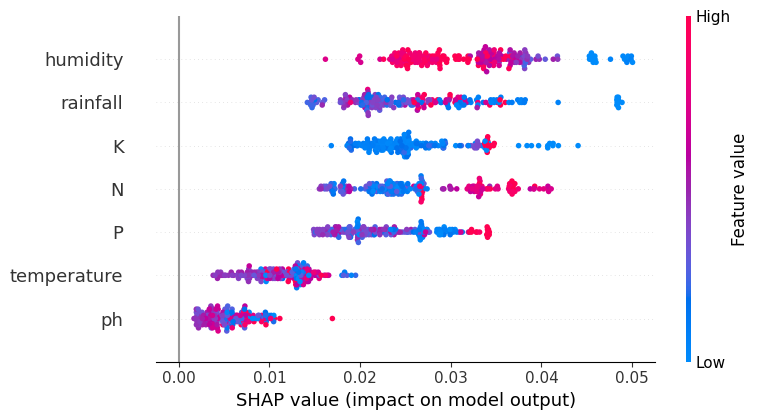

In [5]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# Load model & data (just in case)
model_path = "/content/drive/MyDrive/crop_project/crop_model.pkl"
data_path = "/content/drive/MyDrive/crop_project/Crop_recommendation.csv"

model = joblib.load(model_path)
data = pd.read_csv(data_path)

X = data.drop("label", axis=1)
X_sample = X.sample(200, random_state=0)   # more samples for smoother plot

# Use TreeExplainer (like before)
explainer = shap.TreeExplainer(model)
raw_shap = explainer.shap_values(X_sample)

# ----- HANDLE MULTICLASS SHAP VALUES SAFELY -----

# Case 1: SHAP returns a list (one array per class)
if isinstance(raw_shap, list):
    # each element: (n_samples, n_features)
    arr = np.stack(raw_shap, axis=0)          # (n_classes, n_samples, n_features)
    shap_for_plot = np.mean(np.abs(arr), axis=0)  # (n_samples, n_features)

else:
    # Case 2: SHAP returns a single ndarray
    vals = np.array(raw_shap)
    if vals.ndim == 3:
        n_samples, d2, d3 = vals.shape
        n_features = X_sample.shape[1]

        if d2 == n_features:
            # shape: (n_samples, n_features, n_classes)
            shap_for_plot = np.mean(np.abs(vals), axis=2)
        elif d3 == n_features:
            # shape: (n_samples, n_classes, n_features)
            shap_for_plot = np.mean(np.abs(vals), axis=1)
        else:
            # fallback: average over middle axis
            shap_for_plot = np.mean(np.abs(vals), axis=1)
    else:
        # already (n_samples, n_features)
        shap_for_plot = vals

print("shap_for_plot shape:", shap_for_plot.shape)
print("X_sample shape:", X_sample.shape)

# ----- FINAL: SUMMARY PLOT USING CLEAN 2D SHAP VALUES -----
shap.summary_plot(shap_for_plot, X_sample, feature_names=X_sample.columns)


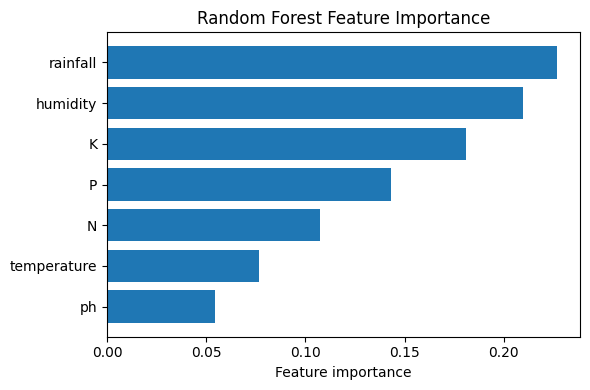

In [6]:
import numpy as np
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)
feature_names = X.columns

plt.figure(figsize=(6,4))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Feature importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/crop_project/feature_importance.png", dpi=300)
plt.show()
